# Day 2 – Quantum Cryptography & Secure Communication (ATIS 2025)

## Teleportation, Superdense Coding, BB84, Anomaly Detection

In [12]:


from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace, state_fidelity
from qiskit_aer.noise import NoiseModel, depolarizing_error
import numpy as np
import matplotlib.pyplot as plt


### Part A – Teleportation core circuit

In [8]:
def arbitrary_single_qubit(theta, phi):
    """Prepare |ψ> = cos(theta/2)|0> + e^{i phi} sin(theta/2)|1> on qubit 0 (in a 3q circuit)."""
    qc = QuantumCircuit(3)
    qc.ry(theta, 0)
    qc.rz(phi,   0)
    return qc

def teleportation_unitary():
    """Teleport from qubit 0 to qubit 2 using unitary (deferred) corrections."""
    qc = QuantumCircuit(3)
    # Create Bell pair between qubits 1 and 2
    qc.h(1)
    qc.cx(1, 2)
    # Bell-basis operation on qubits 0 and 1
    qc.cx(0, 1)
    qc.h(0)
    # Deferred-measurement corrections: X^(m1)Z^(m0) → CX(1→2) then CZ(0→2)
    qc.cx(1, 2)
    qc.cz(0, 2)
    return qc

# --- Build full circuit: prepare |ψ> then teleport it to qubit 2
theta, phi = 1.1, 0.7
prep = arbitrary_single_qubit(theta, phi)
tele = teleportation_unitary()
full = prep.compose(tele)

# Final 3-qubit state after teleportation
psi_out = Statevector.from_instruction(full)

# Reduced state (destination qubit 2)
rho_2 = partial_trace(psi_out, [0, 1])            # DensityMatrix for qubit 2

# Ideal single-qubit |ψ> to compare against
qc_ideal = QuantumCircuit(1)
qc_ideal.ry(theta, 0)
qc_ideal.rz(phi,   0)
psi_ideal_1q = Statevector.from_label('0').evolve(qc_ideal)

# Fidelity between teleported output and the target |ψ>
F = state_fidelity(DensityMatrix(rho_2), psi_ideal_1q)
print(f"Teleportation fidelity ≈ {F:.6f}")  # ≈ 1.000000 in noiseless simulation


Teleportation fidelity ≈ 1.000000


### Sub-task 1 – Vary the Input State

In [10]:
def ideal_state(theta, phi):
    qc = QuantumCircuit(1)
    qc.ry(theta, 0)
    qc.rz(phi, 0)
    return Statevector.from_instruction(qc)

for theta in [0, 1.1, 2.2, 3.3]:
    for phi in [0, 0.7, 1.4, 2.1]:

        # Prepare |ψ> on qubit 0 and apply teleportation unitary
        full = arbitrary_single_qubit(theta, phi).compose(teleportation_unitary())

        # Bob's state after tracing out Alice's qubits
        rho_B = partial_trace(
            Statevector.from_instruction(full),
            [0, 1]
        )

        # Ideal reference state
        psi_ref = ideal_state(theta, phi)

        # Fidelity evaluation
        F = state_fidelity(DensityMatrix(rho_B), psi_ref)

        print(f"Theta={theta:.1f}, Phi={phi:.1f} -> Fidelity={F:.6f}")


Theta=0.0, Phi=0.0 -> Fidelity=1.000000
Theta=0.0, Phi=0.7 -> Fidelity=1.000000
Theta=0.0, Phi=1.4 -> Fidelity=1.000000
Theta=0.0, Phi=2.1 -> Fidelity=1.000000
Theta=1.1, Phi=0.0 -> Fidelity=1.000000
Theta=1.1, Phi=0.7 -> Fidelity=1.000000
Theta=1.1, Phi=1.4 -> Fidelity=1.000000
Theta=1.1, Phi=2.1 -> Fidelity=1.000000
Theta=2.2, Phi=0.0 -> Fidelity=1.000000
Theta=2.2, Phi=0.7 -> Fidelity=1.000000
Theta=2.2, Phi=1.4 -> Fidelity=1.000000
Theta=2.2, Phi=2.1 -> Fidelity=1.000000
Theta=3.3, Phi=0.0 -> Fidelity=1.000000
Theta=3.3, Phi=0.7 -> Fidelity=1.000000
Theta=3.3, Phi=1.4 -> Fidelity=1.000000
Theta=3.3, Phi=2.1 -> Fidelity=1.000000


Question: Does teleportation depend on what state Alice starts with? \
\
In a noiseless scenario, the answer is no. The teleportation protocol works for any arbitrary single-qubit state that Alice wants to send to Bob. \
\
The reason is that the teleportation protocol is designed to transfer the full quantum information of the qubit, regardless of its initial state.


### Sub-task 2 – Noise and Fidelity Check

Theta=1.1, Phi=0.7 -> Fidelity=0.856930


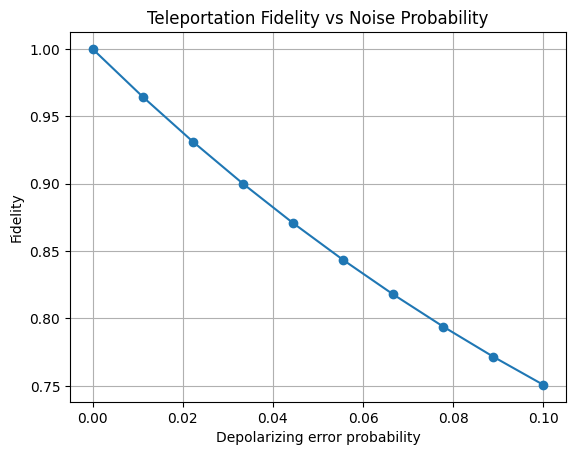

In [20]:
# --- Noise model (single place, parameterized) ---
def make_noise(p):
    noise = NoiseModel()
    noise.add_all_qubit_quantum_error(depolarizing_error(p, 1),
                                      ["ry", "rz", "h"])
    noise.add_all_qubit_quantum_error(depolarizing_error(p, 2),
                                      ["cx"])
    return noise


# --- Teleportation fidelity under one noise level ---
def teleport_fidelity(theta, phi, p):
    sim = AerSimulator(method="density_matrix",
                       noise_model=make_noise(p))

    # Build full circuit and request density matrix
    full = arbitrary_single_qubit(theta, phi).compose(
           teleportation_unitary())
    full.save_density_matrix()

    result = sim.run(full).result()
    rho_full = DensityMatrix(result.data(0)["density_matrix"])

    # Bob's state after tracing out qubits 0 and 1
    rho_B = partial_trace(rho_full, [0, 1])

    # Ideal reference state
    psi_ref = ideal_state(theta, phi)

    return state_fidelity(rho_B, psi_ref)


# --- Example: compute fidelity at fixed theta, phi ---
theta, phi = 1.1, 0.7
F = teleport_fidelity(theta, phi, p=0.05)
print(f"Theta={theta:.1f}, Phi={phi:.1f} -> Fidelity={F:.6f}")


# --- Fidelity vs depolarizing noise plot ---
noise_probs = np.linspace(0, 0.1, 10)
fidelities = [teleport_fidelity(theta, phi, p)
              for p in noise_probs]

plt.plot(noise_probs, fidelities, marker='o')
plt.xlabel("Depolarizing error probability")
plt.ylabel("Fidelity")
plt.title("Teleportation Fidelity vs Noise Probability")
plt.grid(True)
plt.show()
